In [178]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [179]:
df = pd.read_csv('data_co2.csv', names=['Year', 'PPM'], skiprows=1)

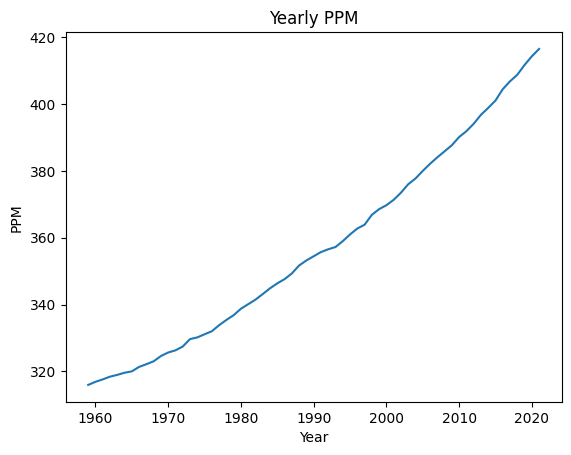

In [180]:
plt.plot(df['Year'], df['PPM'])
plt.xlabel('Year')
plt.ylabel('PPM')
plt.title('Yearly PPM')
plt.show()

In [181]:
years = df['Year']
ppm = df['PPM']

In [182]:
def normalize(data, min, max):
    return (data - min) / (max - min)

In [183]:
from dataclasses import dataclass


@dataclass
class G:
    SPLIT_TIME = int(
        0.8 * len(df))  # on day 80% the training period will end. The rest will belong to the validation set
    WINDOW_SIZE = 10  # how many data points will we take into account to make our prediction
    BATCH_SIZE = 32  # how many items will we supply per batch
    SHUFFLE_BUFFER_SIZE = 1000  # we need this parameter to define the Tensorflow sample buffer

In [184]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    """Divide the time series into training and validation set"""
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    """
    We create time windows to create X and y features.
    For example, if we choose a window of 30, we will create a dataset formed by 30 points as X
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [185]:
# we divide into training and validation set
time_train, series_train, time_valid, series_valid = train_val_split(years, ppm)

series_train_normed = normalize(series_train, ppm.min(axis=0), ppm.max(axis=0))

# let's create the dataset with time windows
dataset = windowed_dataset(series_train_normed)

In [186]:
def create_uncompiled_model():
    # define a sequential model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                               input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1),
    ])

    return model

In [187]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('mae') < 0.03):
            print("\nMAEthreshold reached. Training stopped.")
            self.model.stop_training = True


# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [188]:
def create_model():
    tf.random.set_seed(51)

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mae"])
    return model


model = create_model()

# we train for 20 epochs with and assign the callback
history = model.fit(dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50
2/2 [==============================] - 45s 2s/step - loss: 0.0733 - mae: 0.3285
Epoch 2/50
2/2 [==============================] - 3s 1s/step - loss: 0.1901 - mae: 0.5404
Epoch 3/50
2/2 [==============================] - 3s 1s/step - loss: 0.0489 - mae: 0.2724
Epoch 4/50
2/2 [==============================] - 3s 1s/step - loss: 0.0465 - mae: 0.2617
Epoch 5/50
2/2 [==============================] - 3s 1s/step - loss: 0.0236 - mae: 0.1767
Epoch 6/50
2/2 [==============================] - 3s 1s/step - loss: 0.0050 - mae: 0.0824
Epoch 7/50
2/2 [==============================] - 3s 1s/step - loss: 0.0122 - mae: 0.1474
Epoch 8/50
2/2 [==============================] - 3s 993ms/step - loss: 0.0034 - mae: 0.0654
Epoch 9/50
2/2 [==============================] - 3s 1s/step - loss: 0.0086 - mae: 0.1039
Epoch 10/50
2/2 [==============================] - 3s 1s/step - loss: 0.0050 - mae: 0.0795
Epoch 11/50
2/2 [==============================] - 3s 1s/step - loss: 0.0014 - mae: 0.0473
Epoc

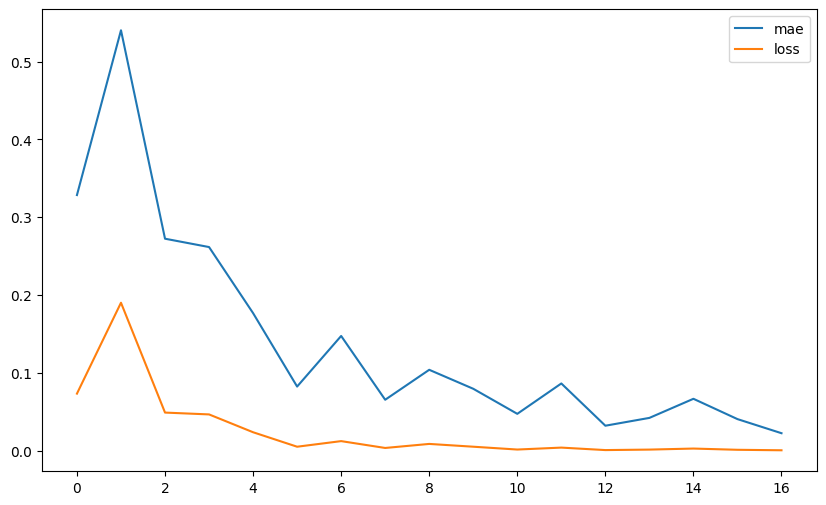

In [189]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [190]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae


def model_forecast(model, series, window_size):
    """This function converts the input series into a dataset with time windows for forecasting"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [191]:
def unnormalize(data, min, max):
    return data * (max - min) + min

2/2 [==============================] - 11s 402ms/step


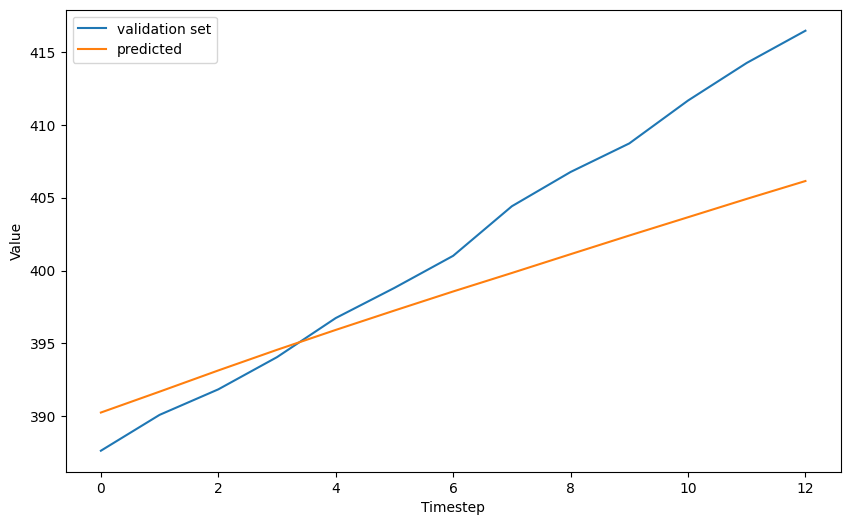

In [192]:
# Prediction on the whole series
all_forecast = model_forecast(model, normalize(ppm, ppm.min(axis=0), ppm.max(axis=0)), G.WINDOW_SIZE).squeeze()

# Validation portion
val_forecast = all_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]


val_forecast = unnormalize(val_forecast, ppm.min(axis=0), ppm.max(axis=0))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(list(series_valid), label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()